In [22]:
import pandas as pd
import numpy as np
np.random.seed(42)
import json
import random

from tqdm import tqdm

Arquivo csv adaptado para diminuir trabalho com tratamento de dados

In [23]:
url = "https://raw.githubusercontent.com/LucasAzvd/teoria-da-decis-o/main/data/i5x25.csv?token=GHSAT0AAAAAABMQ7XE24ODLWYKVZDXOID4YYPNPEZA"
df = pd.read_csv(url)
df.head(2)

,tarefa,maq_1,maq_2,maq_3,maq_4,maq_5,peso,due_date
0,1,2,1,4,7,8,8,6
1,2,8,3,2,1,5,5,6


# Funções objetivo

## Min F1(x)

\begin{equation}
minf_{1}(x)= C_{max} = max\left (\sum_{j=1}^{N}\sum_{k=1}^{N} t_{ij}x_{ijk}  \right )\\
i\epsilon\left\{ i,...,M \right \}
\end{equation}

Essa função nos trás o tempo de execução máximo de uma máquina, somando todas as tarefas que foram executadas na mesma.   
Seu retorno é representado pelo maior tempo de execução das máquinas e sua minimização 

Transforma essa função objetivo em restrição temos:

\begin{equation}
max\left (\sum_{j=1}^{N}\sum_{k=1}^{N} t_{ij}x_{ijk}  \right )\leq \epsilon \\
\end{equation}

In [24]:
def min_f1_restricao(df_alocacao: pd.DataFrame, epsilon: int) -> dict:
    """Minimizar o makespan, calculando o tempo de execução em todas as máquinas 
            e retornando a que mais demora
    Args
        df_alocacao[pd.DataFrame]: Dataframe com a alocação das máquinas
        epsilon[int]: Valor do ∈-restrito no nosso código
    Returns:
        int : O maior tempo de execução das máquinas
    """

    tempo_maximo_atual = max(df_alocacao.iloc[:, 1:6].sum())
    if tempo_maximo_atual > epsilon: # True para restricao violada
        return True
    return False

## Min F2(x)

\begin{equation}
minf_{2}(x)= \sum_{j=1}^{N} w_{j}t_{j}
\end{equation}

Se refere a soma ponderada dos atrasos que ocorreram com a penalidade $W_{j}$.

In [25]:
def min_f2(df_alocacao):
    df_alocacao['penalidade'] = df_alocacao.iloc[:, 1:6].max(axis=1)
    df_alocacao['penalidade'] = df_alocacao['penalidade'] - df_alocacao['due_date']
    df_alocacao.loc[df_alocacao['penalidade'] < 0, 'penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao['penalidade']*df_alocacao['peso']

    penalidade = max(df_alocacao.drop(['tarefa', 'peso', 'due_date'], axis=1).sum())

    return penalidade

## Restrições

Iremos implementar as seguintes restrições na função abaixo:  
`restricao_tarefas_maquinas`
\begin{equation}
 \sum_{i=1}^{M}\sum_{k=1}^{N+1} x_{ijk} = 1,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

`restricao_tempo_máximo`
\begin{equation}
C_{max}\geq  \sum_{i=1}^{M}\sum_{k=1}^{N+1} t_{ij}x_{ijk},\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de validar que um máquina pode ficar sem nenhuma tarefa atribuída.
\begin{equation}
\sum_{k=1}^{N} x_{i0k}\leq 1,\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de verificação de finalização de tarefas antes da atribuição a uma máquina.
\begin{equation}
\sum_{j=1,j\neq h}^{N+1} x_{ijh} - \sum_{k=1,k\neq h}^{N+1} x_{ihk} = 0,\forall h\epsilon \left \{ 1,...,N \right \}e\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata se a tarefa está exutando uma tarefa ou não.
\begin{equation}
C_{ik}\geqslant C_{ij} - L + \left ( t_{ij}+L \right )x_{ijk},\forall \text{j e k}\epsilon \left \{ 1,..,N \right \}
\end{equation}

`restricao_tempo_atraso`
\begin{equation}
T_{j}\geq C_{j}-d,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

Caso alguma restrição seja violada, retornamos **True**.

In [26]:
def restricao_tarefas_maquinas(df_alocacao: pd.DataFrame):
    """Cada tarefa deverá ir para uma máquina obrigatoriamente, garantindo que todas as tarefas sejam executadas.
    Nela verificamos de existe alguma linha vazia no nosso dataframe de linhas de execução, que representaria uma tarefa sem alocar.
    Também verificamos se as tarefas são alocadas apenas para uma máquina.
    """
    soma_linhas_dataframe = df_alocacao.iloc[:, 1:6].nunique(axis=1)
    for i in soma_linhas_dataframe:
        if i != 2:  # Restricao violada
            # print("Restrito: restricao_tarefas_maquinas")
            return True

    return False

In [27]:
def restricao_tempo_maximo(df_alocacao: int, tempo_execucao_maquinas: list):
    """Nesta restrição garantimos que o tempo máximo de execução seja respeitado.
    """
    for tempo_exec in np.array(df_alocacao.iloc[:,1:6].sum()):
        if tempo_exec > tempo_execucao_maquinas: # Viola restrição
            # print("Restrito: restricao_tempo_maximo")
            return True
        else:
            return False

In [28]:
def restricao_tempo_atraso(df_alocacao: True):
    """Restrição referente ao tempo de atraso, ela delimita que o tempo de execução
    da tarefa tem que ser limitado pelo tempo d definido."""
    df_aux = df_alocacao.copy()
    df_aux['tempo_atraso'] = df_aux['due_date'] - df_alocacao.iloc[:, 1:6].max(axis=1)
    
    df_aux['restricao_atraso'] = df_aux['tempo_atraso'] - df_aux['due_date'] + df_alocacao.iloc[:, 1:6].max(axis=1)
    if sum(df_aux['restricao_atraso']):
        # print("Restrito: restricao_tempo_atraso")
        return True
    else:
        return False

## Estrutura de vizinhança

1.   Shift
2.   Swtich
3.   Swap
4.   Two-Shift
5.   Task-Move


In [29]:
def swap(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    quant_maquinas = 5
    tarefa_swap_1 = random.randint(1, quant_tarefas)
    if tarefa_swap_1 == quant_tarefas:
        tarefa_swap_2 = tarefa_swap_1 - 1
    else:
        tarefa_swap_2 = tarefa_swap_1 + 1

    tarefa_swap_1_list = df_alocacao[df_alocacao['tarefa']
                                     == tarefa_swap_1].iloc[:, 1:6].values[0].copy()
    tarefa_swap_2_list = df_alocacao[df_alocacao['tarefa']
                                     == tarefa_swap_2].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(tarefa_swap_1_list)):
        if tarefa_swap_1_list[i] > 0:
            maq_1 = i+1
            df_alocacao.loc[df_alocacao["tarefa"]
                            == tarefa_swap_1, f'maq_{i+1}'] = 0

    for i in range(0, len(tarefa_swap_2_list)):
        if tarefa_swap_2_list[i] > 0:
            maq_2 = i+1
            df_alocacao.loc[df_alocacao["tarefa"] ==
                            tarefa_swap_2, f'maq_{maq_2}'] = 0

    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_1,
                    f'maq_{maq_2}'] = df[df["tarefa"] == tarefa_swap_1][f'maq_{maq_2}']
    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_2,
                    f'maq_{maq_1}'] = df[df["tarefa"] == tarefa_swap_2][f'maq_{maq_1}']

    return df_alocacao

In [30]:
def task_move(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    task_to_move = random.randint(1, quant_tarefas)

    list_tasks = df_alocacao[df_alocacao['tarefa'] ==
                             task_to_move].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(list_tasks)):
        if list_tasks[i] > 0:
            maq = i+1
            df_alocacao.loc[df_alocacao["tarefa"]
                            == task_to_move, f'maq_{maq}'] = 0
            if maq == 5:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move,
                                f'maq_{maq-1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq-1}']
            else:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move,
                                f'maq_{maq+1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq+1}']
            break

    return df_alocacao

In [31]:
def estruturas(df_alocacao, df, k):
    if k==1:
        df_alocacao_new = swap(df_alocacao, df)
    else:
        df_alocacao_new = task_move(df_alocacao, df)
    return df_alocacao_new

## Variáveis

In [32]:
quant_maq = 5
quant_tarefas = df.shape[0]

Alocando as tarefas nas máquinas aleatóriamente

In [33]:
def aloca_tarefas(df_alocacao, quant_tarefas):
    for i in range(0, quant_tarefas):
        maq_aloc = random.randint(1,quant_maq)
        while (df_alocacao[f'maq_{maq_aloc}'].nunique()-1)  == 5:
            maq_aloc = random.randint(1,quant_maq)

        # Pegando tarefa i e atribuindo o valor dela a maquina referente
        df_alocacao.iloc[i][f'maq_{maq_aloc}'] = df[df['tarefa'] == i+1][f'maq_{maq_aloc}'].values[0]
    return df_alocacao


Calculando a penalidade inicial da nossa alocação

In [34]:
def calcula_penalidade(df_alocacao):
    df_alocacao['penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao.iloc[:, 1:6].max(axis=1)
    df_alocacao['penalidade'] = df_alocacao['penalidade'] - df_alocacao['due_date']
    df_alocacao.loc[df_alocacao['penalidade'] < 0, 'penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao['penalidade']*df_alocacao['peso']
    return df_alocacao

In [35]:
def gera_alocacao():
    """Gera alocação para as máquinas aleatoriamente"""
    df_alocacao = df.copy()
    df_alocacao['maq_1'] = 0
    df_alocacao['maq_2'] = 0
    df_alocacao['maq_3'] = 0
    df_alocacao['maq_4'] = 0
    df_alocacao['maq_5'] = 0
    df_alocacao = aloca_tarefas(df_alocacao, quant_tarefas)
    df_alocacao = calcula_penalidade(df_alocacao)
    return df_alocacao

# Execução do nosso algoritmo

In [36]:
def exec_algo(n_execucoes, n_epocas, epsilon, dict_results):

    for n_exec in range(0, n_execucoes):
        df_alocacao = gera_alocacao()
        penalidade_maximo = max(df_alocacao.drop(['tarefa', 'peso', 'due_date'], axis=1).sum())

        list_penalidades = []
        list_penalidades.append(penalidade_maximo)

        k = 1
        for epc in tqdm(range(0, n_epocas)):
        # for epc in range(0, n_epocas):
            penalidade_maximo_execucao = penalidade_maximo

            df_alocacao_new = df_alocacao.copy()
            df_alocacao_new = estruturas(df_alocacao, df, k)
            k=1
            restricao_1 = restricao_tarefas_maquinas(df_alocacao_new)
            restricao_2 = restricao_tempo_maximo(df_alocacao_new, penalidade_maximo_execucao)
            restricao_3 = restricao_tempo_atraso(df_alocacao_new)
            restricao_f1 = min_f1_restricao(df_alocacao_new, epsilon) # Ajusta o valor de epsilon
            if restricao_1 or restricao_2 or restricao_3 or restricao_f1:
                # Se alguma restrição verdadeira, adicionamos os valores antigos a lista
                list_penalidades.append(penalidade_maximo)
                k=0 # Troca do método

            else:
                penalidade_maximo_execucao = min_f2(df_alocacao_new)

                if penalidade_maximo_execucao < penalidade_maximo:
                    penalidade_maximo = penalidade_maximo_execucao
                    df_alocacao = df_alocacao_new.copy()

                list_penalidades.append(penalidade_maximo)

        df_alocacao.to_csv(f"data/arquivos_gerados/exec_{epsilon}.csv", index=False)
        dict_results[f"epsilon_{epsilon}"] = list_penalidades

    return dict_results
    

Os valores para epsilon foram extraídos da execução do algoritmo no TC 02, sendo do maior valor (restrição mais fraca, até o melhor ótimo)

In [37]:
n_epocas = 100
n_execucoes = 1
execucoes_dict = {}
list_epsilon = [100, 80, 60, 40, 20] 
for epsilon in list_epsilon:
    execucoes_dict = exec_algo(n_execucoes, n_epocas, epsilon, execucoes_dict)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100.10it/s]


In [38]:
print("Para execução de f2 temos o seguinte resultado:")
for i in execucoes_dict.keys():
    media = np.mean(execucoes_dict[i])
    std = np.std(execucoes_dict[i])
    max_value = np.max(execucoes_dict[i])
    print(f"Para a execução {i} temos média:{round(media, 2)}, desvio padrão:{round(std, 2)} e valor máximo:{max_value}")

Para execução de f2 temos o seguinte resultado:
Para a execução epsilon_100 temos média:104.92, desvio padrão:16.37 e valor máximo:127
Para a execução epsilon_80 temos média:61.35, desvio padrão:2.66 e valor máximo:86
Para a execução epsilon_60 temos média:74.06, desvio padrão:7.14 e valor máximo:113
Para a execução epsilon_40 temos média:128.82, desvio padrão:12.36 e valor máximo:183
Para a execução epsilon_20 temos média:150.0, desvio padrão:0.0 e valor máximo:150


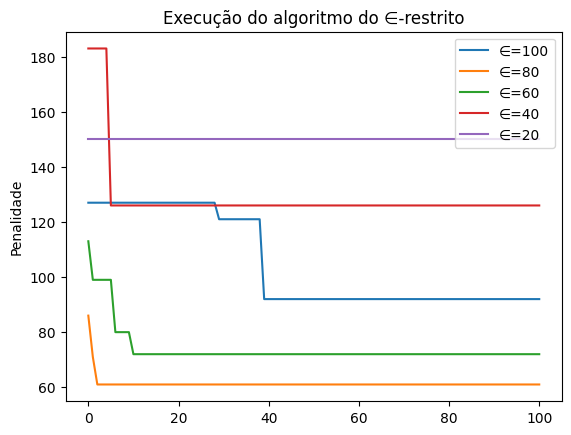

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(execucoes_dict['epsilon_100'], label='∈=100')
plt.plot(execucoes_dict['epsilon_80'], label='∈=80')
plt.plot(execucoes_dict['epsilon_60'], label='∈=60')
plt.plot(execucoes_dict['epsilon_40'], label='∈=40')
plt.plot(execucoes_dict['epsilon_20'], label='∈=20')

plt.title("Execução do algoritmo do ∈-restrito")
plt.ylabel("Penalidade")
plt.legend()
plt.show()

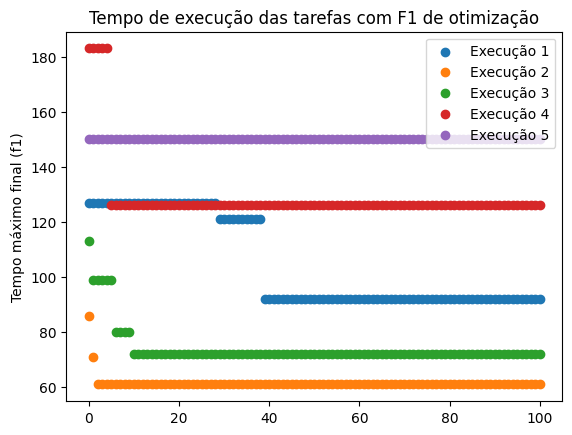

In [40]:
import matplotlib.pyplot as plt

plt.scatter(range(0,101), execucoes_dict['epsilon_100'], label='Execução 1')
plt.scatter(range(0,101), execucoes_dict['epsilon_80'], label='Execução 2')
plt.scatter(range(0,101), execucoes_dict['epsilon_60'], label='Execução 3')
plt.scatter(range(0,101), execucoes_dict['epsilon_40'], label='Execução 4')
plt.scatter(range(0,101), execucoes_dict['epsilon_20'], label='Execução 5')

plt.title("Tempo de execução das tarefas com F1 de otimização")
plt.ylabel("Penalidade final (f2)")
plt.ylabel("Tempo máximo final (f1)")
plt.legend()
plt.show()

## Calculado resultados para melhor execução

A nossa melhor execução se apresenta com ∈=80

In [72]:
df = pd.read_csv('data/arquivos_gerados/exec_80.csv')

### Calculando tempo de cada máquina

A máquina 2 apresentou o maior tempo, sendo assim o tempo de execução das tarefas.  
+ Tempo máquina 2: 36

Tempo de pensalidade:  
+ Tempo de pensalidade: 114

In [82]:
df[['maq_1', 'maq_2', 'maq_3', 'maq_4', 'maq_5', 'penalidade']].sum()

maq_1          33
maq_2          36
maq_3          30
maq_4          20
maq_5          17
penalidade    114
dtype: int64

## Calculando atraso e adiantamento

In [94]:
df_adiantamento = df.copy()

In [95]:
df_adiantamento['maq_1_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_1']
df_adiantamento['maq_2_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_2']
df_adiantamento['maq_3_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_3']
df_adiantamento['maq_4_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_4']
df_adiantamento['maq_5_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_5']

Para calcular o atraso e adiantamento, vamos calcular o tempo resultante em cada máquina.  
+ Valores positivos representam adiantamentos
+ Valores negativos representam atrasos  

Realizando a soma dessas colunas temos o valor resultante

In [96]:
np.mean(df_adiantamento[['maq_1_adt', 'maq_2_adt',
                         'maq_3_adt', 'maq_4_adt', 'maq_5_adt']].sum())

122.8

O tempo médio de atraso e adiantamento entre as máquinas é **122,8 dias**, arredondando para **123 dias**.

# Calculando adiantamento

Para calcular o dataframe vamos transformar todos os valores negativos em 0

In [97]:
df_adiantamento = df.copy()

In [98]:
df_adiantamento['maq_1_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_1']
df_adiantamento['maq_2_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_2']
df_adiantamento['maq_3_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_3']
df_adiantamento['maq_4_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_4']
df_adiantamento['maq_5_adt'] = df_adiantamento['due_date'] - df_adiantamento['maq_5']

In [99]:
df_adiantamento.loc[df_adiantamento['maq_1_adt'] < 0, 'maq_1_adt'] = 0
df_adiantamento.loc[df_adiantamento['maq_2_adt'] < 0, 'maq_2_adt'] = 0
df_adiantamento.loc[df_adiantamento['maq_3_adt'] < 0, 'maq_3_adt'] = 0
df_adiantamento.loc[df_adiantamento['maq_4_adt'] < 0, 'maq_4_adt'] = 0
df_adiantamento.loc[df_adiantamento['maq_5_adt'] < 0, 'maq_5_adt'] = 0

In [100]:
np.mean(df_adiantamento[['maq_1_adt', 'maq_2_adt',
                         'maq_3_adt', 'maq_4_adt', 'maq_5_adt']].sum())

128.6

O tempo médio de atraso e adiantamento entre as máquinas é **128,6 dias**, arredondando para **129 dias**.